### Predicting Likelihood of Strokes
#### Contents
1. Reading data
2. Feature engineering
3. Model building
4. Evaluation

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf

In [4]:
# Read data
df = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
print(df.sample())
df.info()

         id  gender  age  hypertension  heart_disease ever_married work_type  \
4128  34184  Female  2.0             0              0           No  children   

     Residence_type  avg_glucose_level   bmi smoking_status  stroke  
4128          Rural              76.52  14.8        Unknown       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_sta

## Feature Engineering

In [5]:
# Drop NA columns
df = df.dropna()
df["is_urban_residence"] = [1 if value == "Urban" else 0 for value in df["Residence_type"]]
df["is_female"] = [1 if value == "Female" else 0 for value in df["gender"]]
df["previously_married"] = [1 if value == "Female" else 0 for value in df["ever_married"]]
df.drop(["Residence_type", "gender", "ever_married", "id"], axis=1, inplace=True)
df.head(10)
df_encoding = df.iloc[:,:].values
print(df)

       age  hypertension  heart_disease      work_type  avg_glucose_level  \
0     67.0             0              1        Private             228.69   
2     80.0             0              1        Private             105.92   
3     49.0             0              0        Private             171.23   
4     79.0             1              0  Self-employed             174.12   
5     81.0             0              0        Private             186.21   
...    ...           ...            ...            ...                ...   
5104  13.0             0              0       children             103.08   
5106  81.0             0              0  Self-employed             125.20   
5107  35.0             0              0  Self-employed              82.99   
5108  51.0             0              0        Private             166.29   
5109  44.0             0              0       Govt_job              85.28   

       bmi   smoking_status  stroke  is_urban_residence  is_female  \
0    

In [6]:
# Categorical feature encoding
label_encoder = LabelEncoder()
df_encoding[:,3]=label_encoder.fit_transform(df_encoding[:,3])
df_encoding[:,6]=label_encoder.fit_transform(df_encoding[:,6])
print(df_encoding)


[[67.0 0 1 ... 1 0 0]
 [80.0 0 1 ... 0 0 0]
 [49.0 0 0 ... 1 1 0]
 ...
 [35.0 0 0 ... 0 1 0]
 [51.0 0 0 ... 0 0 0]
 [44.0 0 0 ... 1 1 0]]


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

transformer = ColumnTransformer(transformers=[("encode", OneHotEncoder(), [3, 6])], remainder="passthrough")
df_encoded_array = transformer.fit_transform(df_encoding)
df_encoded = pd.DataFrame(df_encoded_array)
df_encoded.drop(0, axis=1, inplace=True)

In [8]:
# Train/Test Split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x = df_encoded.drop(14, axis=1)
y = df_encoded[14]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
# Data scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [10]:
# Model
tf.random.set_seed(42)


model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

#X = np.asarray(X).astype(np.float32)
history = model.fit(np.asarray(x_train_scaled).astype(np.float32), np.asarray(y_train).astype(np.float32), epochs=100)

2022-03-11 00:10:05.858019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-11 00:10:05.858071: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-11 00:10:05.858090: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Aaron-Ginder-PC): /proc/driver/nvidia/version does not exist
2022-03-11 00:10:05.936742: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/mnt/c/Users/aaron/Documents/git/gcp-predicting-strokes/.venv/lib/python3.8/site-packages/keras/optimizer_v

Epoch 1/100
123/123 [==============================] - 12s 2ms/step - loss: 0.3601 - accuracy: 0.9460 - precision: 0.0172 - recall: 0.0064 
Epoch 2/100
123/123 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.9593 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/100
123/123 [==============================] - 0s 2ms/step - loss: 0.1583 - accuracy: 0.9598 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/100
123/123 [==============================] - 0s 2ms/step - loss: 0.1821 - accuracy: 0.9587 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/100
123/123 [==============================] - 0s 2ms/step - loss: 0.1649 - accuracy: 0.9603 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/100
123/123 [==============================] - 0s 2ms/step - loss: 0.1448 - accuracy: 0.9600 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/100
123/123 [==============================] - 0s 2ms/step - loss: 0.1471 - accuracy: 0.9603 - precision: 0.0000e+00 - rec

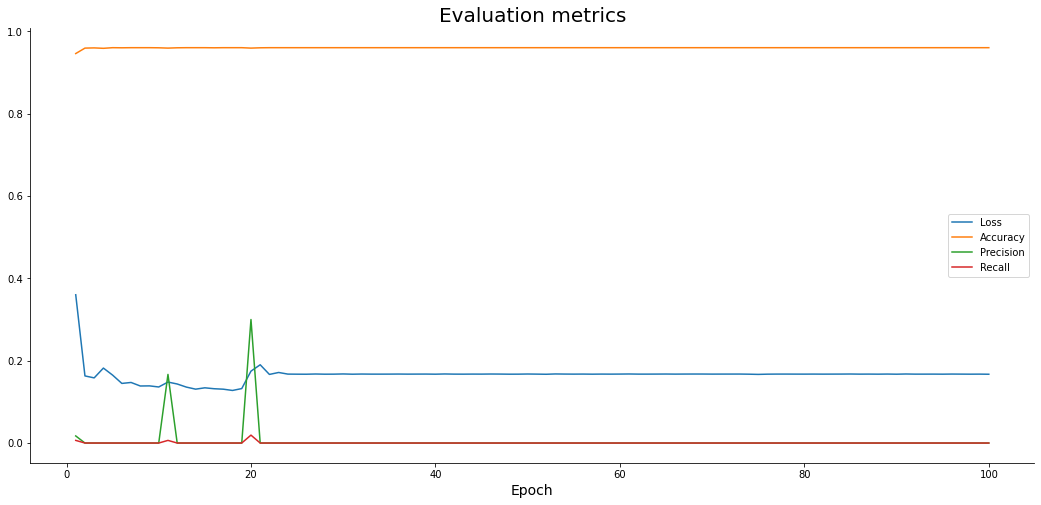

In [11]:
# Evaluation
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

plt.plot(
    np.arange(1, 101), 
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, 101), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    np.arange(1, 101), 
    history.history['precision'], label='Precision'
)
plt.plot(
    np.arange(1, 101), 
    history.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [12]:
predictions = model.predict(x_test_scaled)
prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]

In [13]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, prediction_classes))

ValueError: Classification metrics can't handle a mix of unknown and binary targets